**This notebook demonstrates decoherence (energy relaxation and phase decay)**
$$
   \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
   \newcommand{\ket}[1]{\left|{#1}\right\rangle}
   \newcommand{\bra}[1]{\left\langle{#1}\right|}
$$

Decoherence results in information loss arising from environmental disturbance. Examples of decoherence are:
1. energy relaxation from the excited $\ket{1}$ state to the ground state $\ket{0}$
2. dephasing (which only affects superposition states).

Decoherence causes pure states to become mixed states, which lie inside the Bloch sphere.
The density matrix form of a mixed state $\ket{\psi}$ is given by:
$$
\rho = \ket{\psi}\bra{\psi} = \sum_k p_k \ket{\psi_k}\bra{\psi_k}.
$$

Note: these examples are taken from the tutorial [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/relaxation_and_decoherence.ipynb)

*Example: demonstrate energy relaxtion, $T_1$*
1. Construct a series of circuits, each starting with a single qubit in the excited state (*i.e.* $\ket{1}$)
2. Measure each circuit after increasing amounts of time have elapsed.

In [1]:
import os,sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import qiskit
from qiskit import IBMQ
from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

from qiskit.ignis.characterization.coherence import T1Fitter, T2StarFitter, T2Fitter
from qiskit.ignis.characterization.coherence import t1_circuits, t2_circuits, t2star_circuits

# Import local tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import backend_tools

# Get a backend (can use the simulator as there is a Noise model)
IBMQ.load_accounts()
backend = backend_tools.get_device(use_sim=True, min_qubits=2)

Wait times for T1 test:
   time: 1.00000 microseconds
   time: 1.50000 microseconds
   time: 2.10000 microseconds
   time: 2.70000 microseconds
   time: 3.30000 microseconds
   time: 3.90000 microseconds
   time: 4.50000 microseconds
   time: 5.10000 microseconds
   time: 5.70000 microseconds
   time: 6.30000 microseconds
   time: 6.90000 microseconds
   time: 7.50000 microseconds
   time: 8.10000 microseconds
   time: 8.60000 microseconds
   time: 9.20000 microseconds
   time: 9.80000 microseconds
   time: 10.40000 microseconds
   time: 11.00000 microseconds
   time: 11.60000 microseconds
   time: 12.20000 microseconds
   time: 12.80000 microseconds
   time: 13.40000 microseconds
   time: 14.00000 microseconds
   time: 14.60000 microseconds
   time: 15.20000 microseconds
   time: 15.70000 microseconds
   time: 16.30000 microseconds
   time: 16.90000 microseconds
   time: 17.50000 microseconds
   time: 18.10000 microseconds
   time: 18.70000 microseconds
   time: 19.30000 microseconds


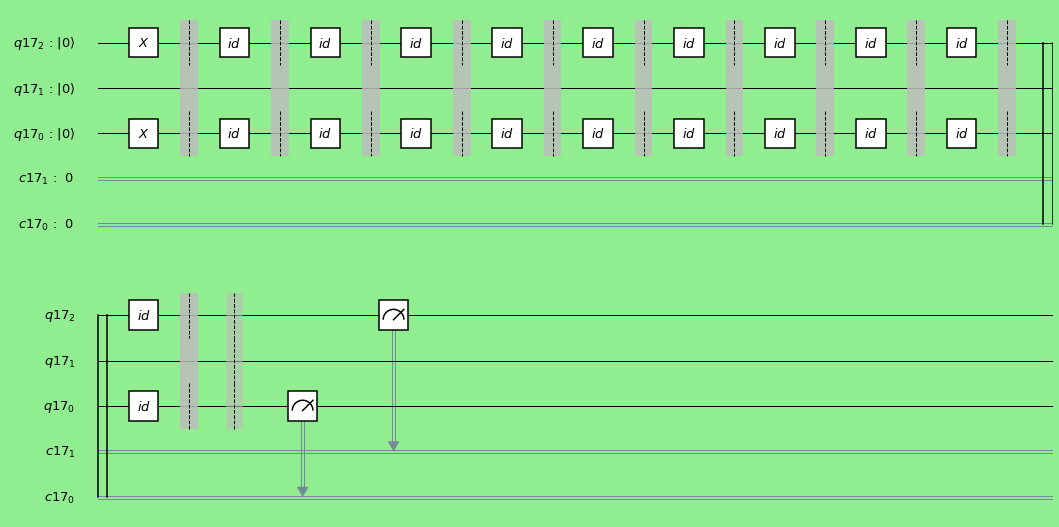

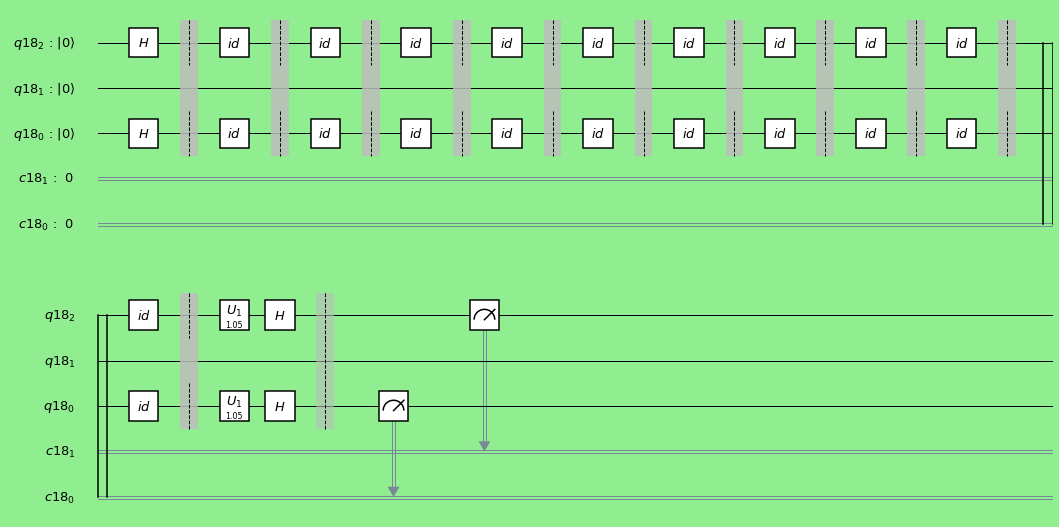

In [16]:
# Build the circuits

def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

# For each test, create 50 circuits with the number of identity gates ranging from 10 to 300,
# each with a wait time of 0.1 microseconds
num_of_gates = (np.linspace(10, 300, 50)).astype(int)
gate_time = 0.1

# Note that it is possible to measure several qubits in parallel
qubits = [0, 2]

# List of circuits with increasing wait time

# Energy relaxation test, time T1
t1_circs, t1_xdata = t1_circuits(num_of_gates, gate_time, qubits)
print("Wait times for T1 test:")
for t in t1_xdata:
    print("   time: {:.5f} microseconds".format(t))

# Ramsey dephasing test, time T2-star
# nosc = number of oscillations i.e. it sets the phase parameter, phi
t2star_circs, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)

# Echo dephasing test, time T2
# - do half the number of identity (wait) gates before the X gate (pi/2 pulse)
t2echo_circs, t2echo_xdata = t2_circuits(np.floor(num_of_gates/2).astype(int), 
                                         gate_time, qubits)

t2cpmg_circs, t2cpmg_xdata = t2_circuits(np.floor(num_of_gates/6).astype(int), 
                                         gate_time, qubits, 
                                         n_echos=5, phase_alt_echo=True)

*$T_1$ circuit*

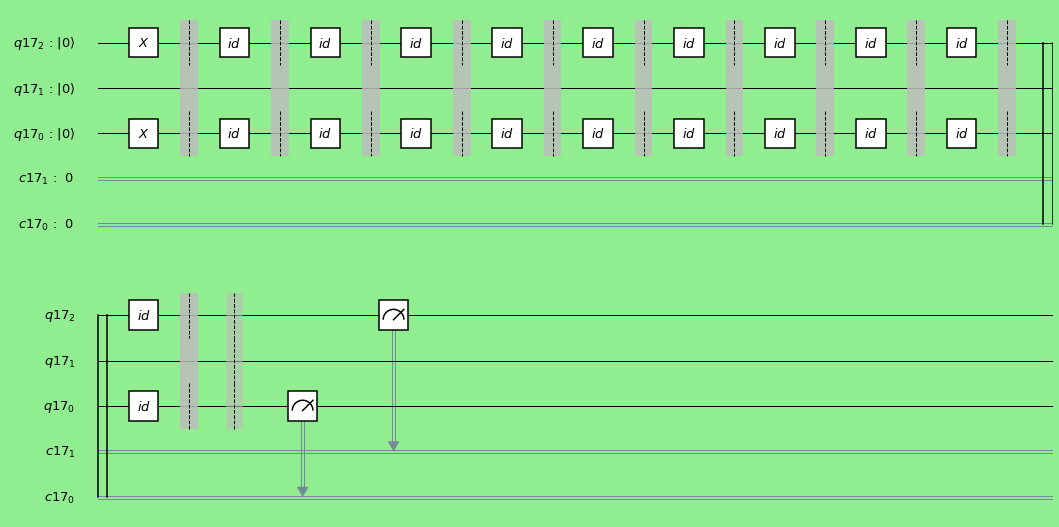

In [25]:
# Draw one of the circuits
style = {'backgroundcolor': 'lightgreen'}
show_figure(t1_circs[0].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

*$T_2^*$ Ramsey circuit*

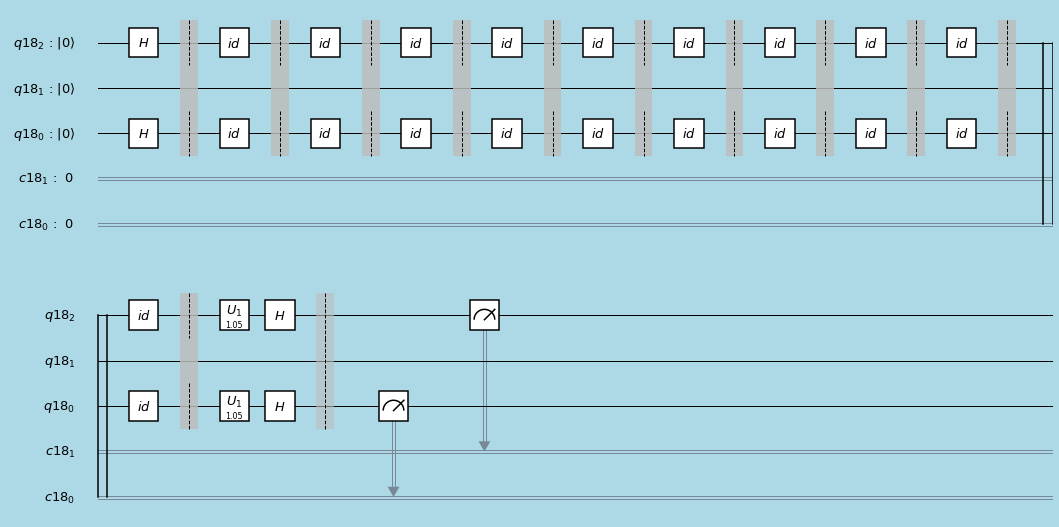

In [24]:
# Draw one of the circuits
style = {'backgroundcolor': 'lightblue'}
show_figure(t2star_circs[0].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

*$T_2$ echo circuit*

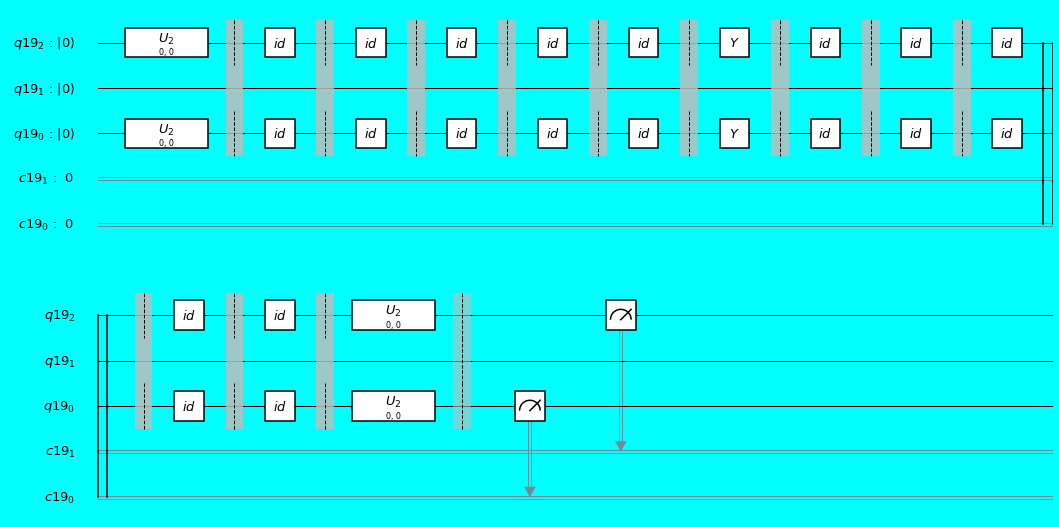

In [30]:
# Draw one of the circuits
style = {'backgroundcolor': 'cyan'}
show_figure(t2echo_circs[0].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

*$T_2$ CPMG circuit*

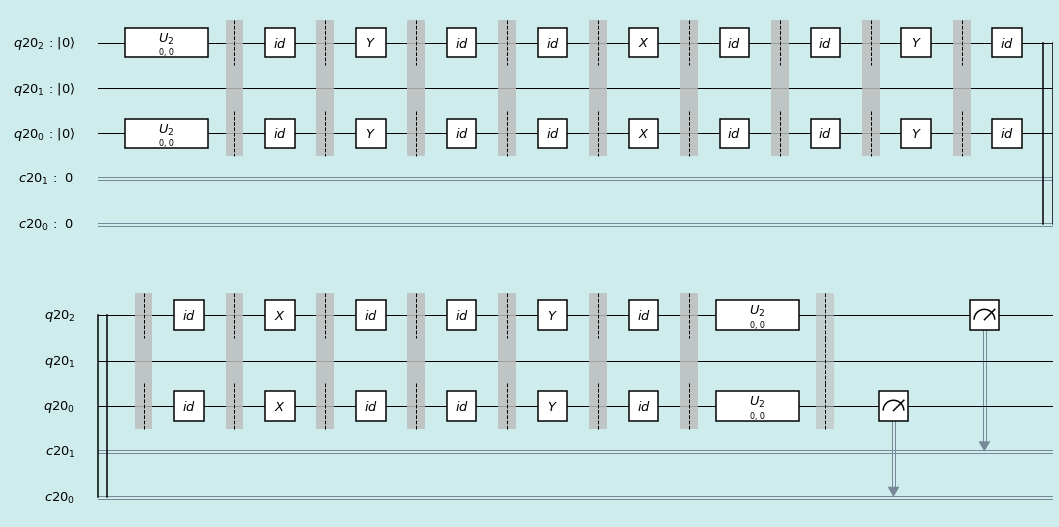

In [32]:
# Draw one of the circuits
style = {'backgroundcolor': '#CFECEC'}
show_figure(t2cpmg_circs[0].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

In [9]:
shots = 400

# Let the simulator simulate the following times for qubits 0 and 2:
# - these are "constants" that we choose
t_q0 = 25.0
t_q2 = 15.0

# Define T1 and T2 noise:
t1_noise_model = NoiseModel()
t1_noise_model.add_quantum_error(
    thermal_relaxation_error(t_q0, 2*t_q0, gate_time), 
    'id', [0])
t1_noise_model.add_quantum_error(
    thermal_relaxation_error(t_q2, 2*t_q2, gate_time), 
    'id', [2])

t2_noise_model = NoiseModel()
t2_noise_model.add_quantum_error(
    thermal_relaxation_error(np.inf, t_q0, gate_time, 0.5), 
    'id', [0])
t2_noise_model.add_quantum_error(
    thermal_relaxation_error(np.inf, t_q2, gate_time, 0.5), 
    'id', [2])

# Run the simulator
t1_backend_result = qiskit.execute(t1_circs, backend, shots=shots,
                                   noise_model=t1_noise_model, optimization_level=0).result()
t2star_backend_result = qiskit.execute(t2star_circs, backend, shots=shots,
                                       noise_model=t2_noise_model, optimization_level=0).result()
t2echo_backend_result = qiskit.execute(t2echo_circs, backend, shots=shots,
                                       noise_model=t2_noise_model, optimization_level=0).result()

# It is possible to split the circuits into multiple jobs and then give the results to the fitter as a list:
t2cpmg_backend_result1 = qiskit.execute(t2cpmg_circs[0:5], backend,
                                        shots=shots, noise_model=t2_noise_model,
                                        optimization_level=0).result()
t2cpmg_backend_result2 = qiskit.execute(t2cpmg_circs[5:], backend,
                                        shots=shots, noise_model=t2_noise_model,
                                        optimization_level=0).result()

### Display results ###

[22.124604275718756, 15.382542676820348]
[1.7658983900515115, 0.7072913344262464]
{'0': [array([ 0.93168507, 22.12460428,  0.07372496]), array([ 1.02023941, 15.38254268, -0.01620498])]}
{'0': [array([0.03797371, 1.76589839, 0.04160231]), array([0.01607924, 0.70729133, 0.01949794])]}


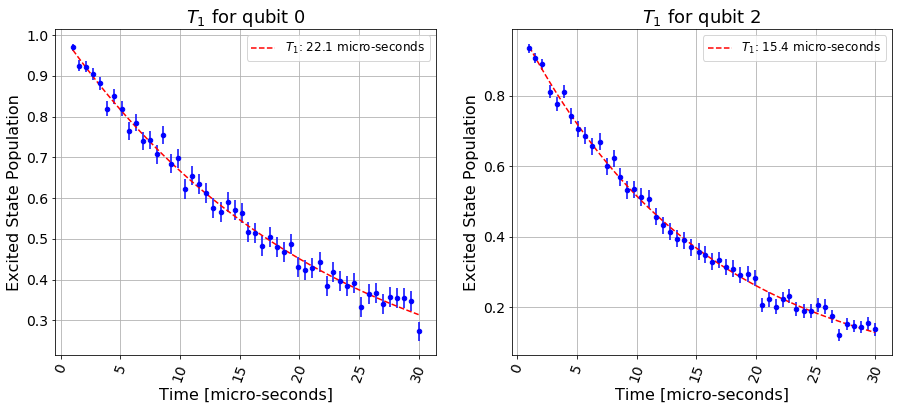

In [10]:
# Fitting T1
plt.figure(figsize=(15, 6))

t1_fit = T1Fitter(t1_backend_result, t1_xdata, qubits,
                  fit_p0=[1, t_q0, 0],
                  fit_bounds=([0, 0, -1], [2, 40, 1]))
print(t1_fit.time())
print(t1_fit.time_err())
print(t1_fit.params)
print(t1_fit.params_err)

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t1_fit.plot(i, ax=ax)
plt.show()

Execute the backend again to get more statistics, and add the results to the previous ones:

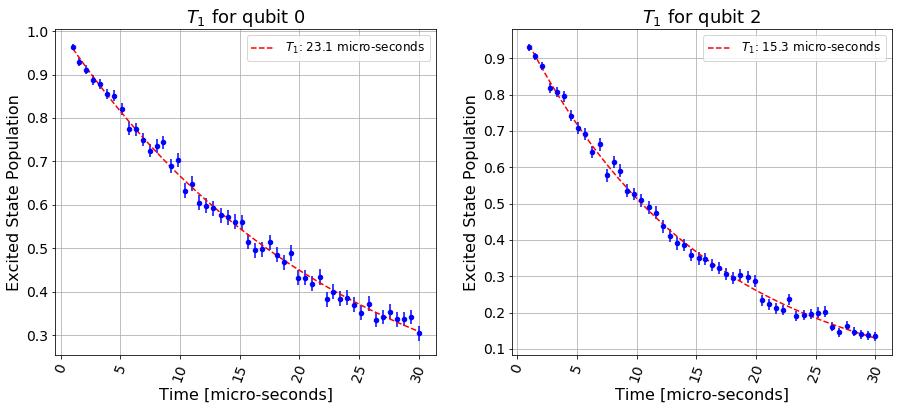

In [11]:
t1_backend_result_new = qiskit.execute(t1_circs, backend,
                                       shots=shots, noise_model=t1_noise_model,
                                       optimization_level=0).result()
t1_fit.add_data(t1_backend_result_new)

plt.figure(figsize=(15, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t1_fit.plot(i, ax=ax)    
plt.show()

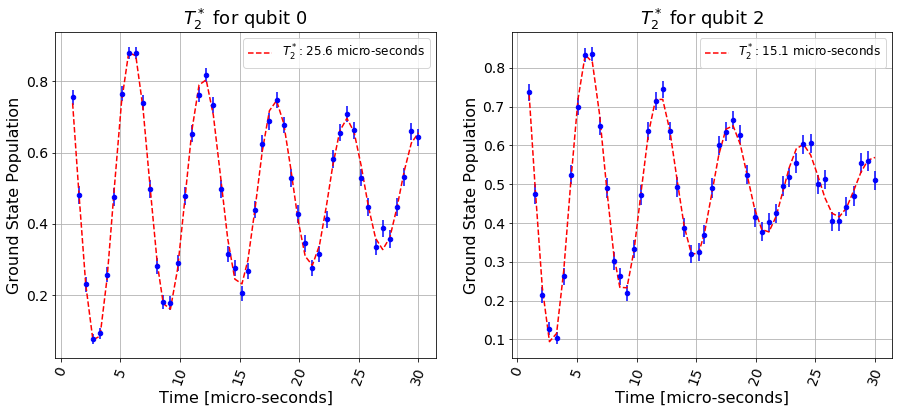

In [12]:
# Fitting T2*

%matplotlib inline

t2star_fit = T2StarFitter(t2star_backend_result, t2star_xdata, qubits,
                          fit_p0=[0.5, t_q0, osc_freq, 0, 0.5],
                          fit_bounds=([-0.5, 0, 0, -np.pi, -0.5],
                                      [1.5, 40, 2*osc_freq, np.pi, 1.5]))

plt.figure(figsize=(15, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t2star_fit.plot(i, ax=ax)    
plt.show()

{'0': [array([ 0.55342587, 30.27182628,  0.4455497 ]), array([ 0.51726226, 15.38869236,  0.48535099])]}


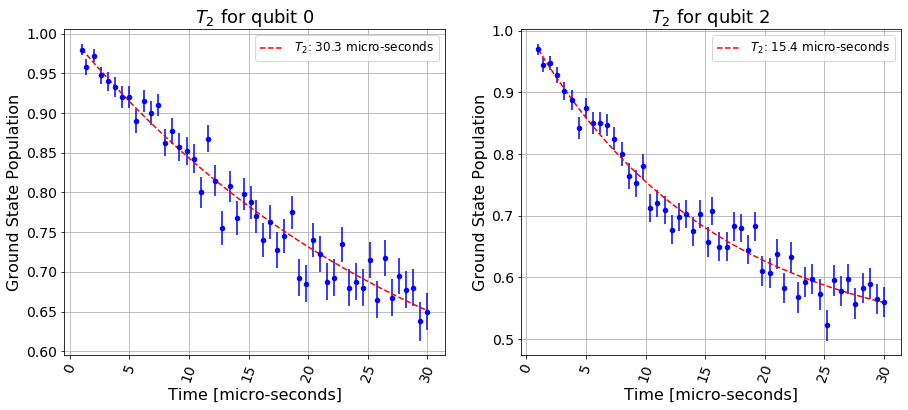

In [13]:
# Fitting T2 single echo

%matplotlib inline

t2echo_fit = T2Fitter(t2echo_backend_result, t2echo_xdata, qubits,
                      fit_p0=[0.5, t_q0, 0.5],
                      fit_bounds=([-0.5, 0, -0.5],
                                  [1.5, 40, 1.5]))

print(t2echo_fit.params)

plt.figure(figsize=(15, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t2echo_fit.plot(i, ax=ax)    
plt.show()

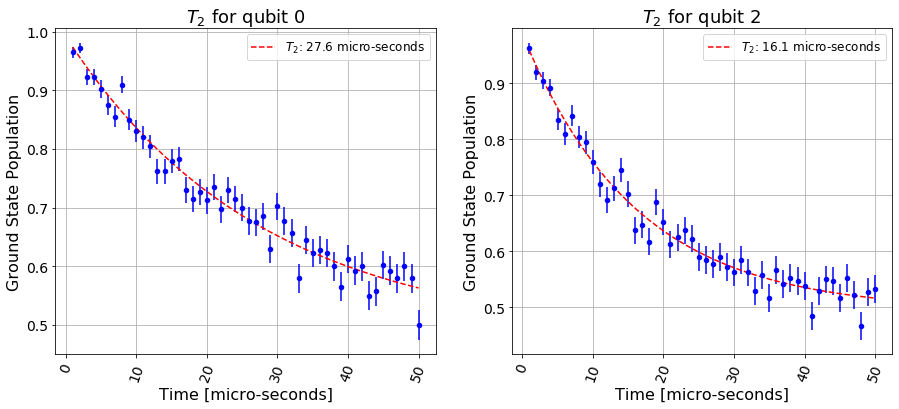

In [14]:

# Fitting T2 CPMG

%matplotlib inline

t2cpmg_fit = T2Fitter([t2cpmg_backend_result1, t2cpmg_backend_result2],
                      t2cpmg_xdata, qubits,
                      fit_p0=[0.5, t_q0, 0.5],
                      fit_bounds=([-0.5, 0, -0.5],
                                  [1.5, 40, 1.5]))

plt.figure(figsize=(15, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t2cpmg_fit.plot(i, ax=ax)
plt.show()